In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from trainlib import lagndelay, scale, split

%matplotlib inline

In [38]:
#### 2. 데이터 불러오기 ####
data_df = pd.read_csv("../data/data/pca_result.csv", index_col=0)
data_df.head()

,0,1,2,3,4
0,-0.887683,0.214421,0.299873,-0.114686,-0.501998
1,-0.756648,0.188893,0.318678,0.335199,-0.403304
2,-0.939818,0.145828,0.301678,0.525366,0.002468
3,-0.983172,0.160053,0.289109,0.326403,0.401851
4,-0.858838,0.164894,0.296521,-0.111617,0.495942


In [39]:
data4ind = pd.read_csv('../data/data/합천_댐기상종합_forTrain.csv', index_col=0)

In [40]:
# data_df.index = data4ind.index.values

In [41]:
scaler = MinMaxScaler()
df_scaled = scale(scaler, data4ind)


In [42]:
df_scaled['당일유입량']

0       0.002319
1       0.002477
2       0.002003
3       0.003215
4       0.004217
          ...   
8490    0.001423
8491    0.001212
8492    0.001370
8493    0.001634
8494    0.001739
Name: 당일유입량, Length: 8495, dtype: float64

In [43]:
data_df['당일유입량'] = df_scaled['당일유입량'].values

In [44]:
data_df

,0,1,2,3,4,당일유입량
0,-0.887683,0.214421,0.299873,-0.114686,-0.501998,0.002319
1,-0.756648,0.188893,0.318678,0.335199,-0.403304,0.002477
2,-0.939818,0.145828,0.301678,0.525366,0.002468,0.002003
3,-0.983172,0.160053,0.289109,0.326403,0.401851,0.003215
4,-0.858838,0.164894,0.296521,-0.111617,0.495942,0.004217
...,...,...,...,...,...,...
8490,-0.436874,-0.739427,-0.499157,-0.480140,-0.218552,0.001423
8491,-0.301369,-0.787262,-0.464599,-0.121720,-0.496376,0.001212
8492,-0.334915,-0.795293,-0.463374,0.319214,-0.393882,0.001370
8493,-0.316532,-0.790192,-0.462190,0.516955,0.006013,0.001634


In [ ]:


df2 = data_df.copy()
num_lags = 10 # number of lags and window lenghts for mean aggregation
delay = 3 # predict target five steps ahead
y = '당일유입량'
df_processed = lagndelay(num_lags, delay, df2, y)

In [31]:
# scaler = MinMaxScaler()
# df_scaled = scale(scaler, df_processed)

In [46]:
df_train, df_test = split(0.8, df_processed)

In [47]:
h2o.init(ip="localhost", port=54323, nthreads=-1)
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54323. connected.


H2O_cluster_uptime:,4 hours 16 mins
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_jewel_i7ubb2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.561 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [48]:
hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)
X = hf_train.columns
X.remove(y)

In [49]:
aml = H2OAutoML(max_runtime_secs = 600,
                seed = 42)
aml.train(x = X, 
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),0/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [50]:
lb = aml.leaderboard
lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_4_AutoML_2_20230527_192813,0.0343018,0.00117661,0.0100376,0.0279524,0.00117661
GBM_grid_1_AutoML_2_20230527_192813_model_5,0.0346863,0.00120314,0.0103164,0.0283159,0.00120314
DeepLearning_1_AutoML_2_20230527_192813,0.0349805,0.00122364,0.00995566,0.0283065,0.00122364
GBM_grid_1_AutoML_2_20230527_192813_model_52,0.0351277,0.00123395,0.0111488,0.0281432,0.00123395
GBM_grid_1_AutoML_2_20230527_192813_model_43,0.0353982,0.00125303,0.0131222,0.0289301,0.00125303
XGBoost_grid_1_AutoML_2_20230527_192813_model_19,0.0355578,0.00126436,0.0117854,0.029796,0.00126436
GBM_grid_1_AutoML_2_20230527_192813_model_11,0.0357806,0.00128025,0.0114498,0.0295135,0.00128025
DRF_1_AutoML_2_20230527_192813,0.0358945,0.00128842,0.0118606,0.0298262,0.00128842
StackedEnsemble_BestOfFamily_2_AutoML_2_20230527_192813,0.0359012,0.00128889,0.0131786,0.0298068,0.00128889
GBM_grid_1_AutoML_2_20230527_192813_model_21,0.0360321,0.00129831,0.0130121,0.0300974,0.00129831


In [51]:
leader_model = aml.leader
hf_test_predict = leader_model.predict(hf_test)
df_results = pd.DataFrame()
df_results['ground_truth'] = df_test[y].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results.head()

,ground_truth,predictions
0,0.001897,0.011392
1,0.000896,0.016915
2,0.001634,0.016404
3,0.000896,0.017340
4,0.000158,0.010805


R2 =  0.28708857809724736


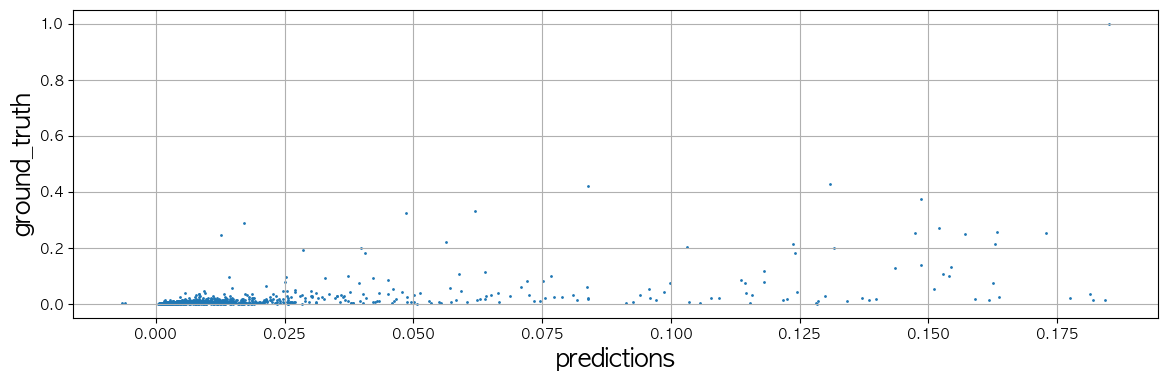

In [52]:
from matplotlib import pyplot as plt
from scipy import stats
plt.rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['axes.grid'] = True


slope, intercept, r_value, p_value, std_err = stats.linregress(x=df_results['predictions'],y=df_results['ground_truth'])
print('R2 = ',r_value*r_value)
plt.scatter(x=df_results['predictions'],y=df_results['ground_truth'],s=1)
plt.xlabel('predictions',fontsize=18)
plt.ylabel('ground_truth',fontsize=18)
plt.show()


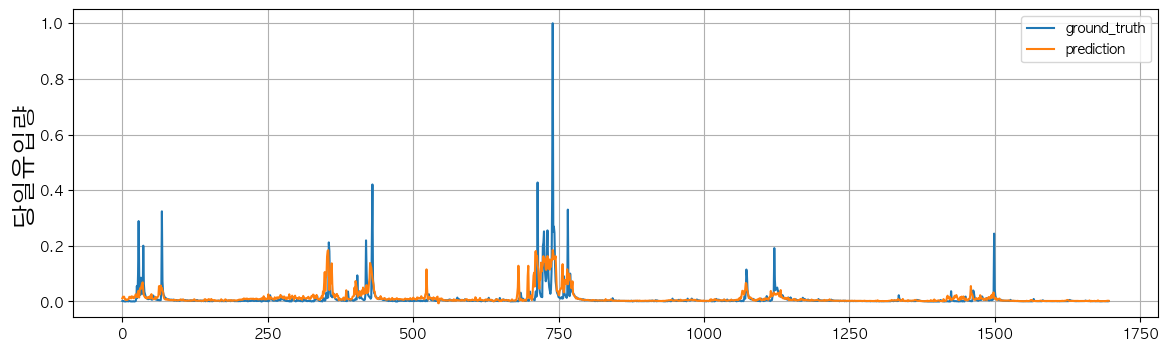

In [53]:
plt.plot(df_results['ground_truth'])
plt.plot(df_results['predictions'])
plt.ylabel(y,fontsize=18)
plt.legend(['ground_truth','prediction'])
plt.show()